## Task: Solve a Regression Problem Using NumPy Only

Implement a **Linear Regression** algorithm in two versions:

1. **Normal Equation (analytical solution)**.
2. **Gradient Descent with L1 and L2 regularization**.

### Goal:
Achieve **$ R^2 > 0.9 $** on the provided dataset.


### Hints:
- Try different scalers.
- Experiment with **periodic** and **polynomial** features.


Clear memory

In [4]:
%reset -f
import gc
gc.collect()

0

### Import libraries

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, time, json
sns.set_style('whitegrid')
pd.set_option('display.max_columns', None)  # количество отображаемых полей
pd.set_option('display.max_rows', None)  # количество отображаемых строк
warnings.simplefilter('ignore', category=FutureWarning)  # отключаем бесячие предупреждения
warnings.simplefilter('ignore', category=DeprecationWarning)  # отключаем бесячие предупреждения
%matplotlib inline

# Load Regression dataset

In [6]:
df = pd.read_csv('Regression_Example_Dataset.csv', encoding='utf-8')

In [7]:
df.head()

,x1,x2,x3,target
0,-1.254599,4.507143,2.319939,-0.264123
1,0.986585,-3.439814,-3.440055,-2.345773
2,-4.419164,3.661761,1.011150,3.318993
3,2.080726,-4.794155,4.699099,-7.400388
4,3.324426,-2.876609,-3.181750,-2.652692


Check the shape of the dataset

In [8]:
df.shape

(1000, 4)

Check the main info about dataset

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      1000 non-null   float64
 1   x2      1000 non-null   float64
 2   x3      1000 non-null   float64
 3   target  1000 non-null   float64
dtypes: float64(4)
memory usage: 31.4 KB


Check some stats

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
x1,1000.0,0.119800,2.868364,-4.998653,-2.414733,0.182531,2.612538,4.997177
x2,1000.0,-0.057751,2.962779,-4.999884,-2.648661,0.087306,2.599536,4.983475
x3,1000.0,-0.065253,2.916940,-4.986464,-2.590055,-0.069142,2.339353,4.966969
target,1000.0,-2.402440,3.954104,-13.433785,-5.536656,-1.376401,0.742384,4.275243


Check missing values

In [11]:
df.isna().sum()

x1        0
x2        0
x3        0
target    0
dtype: int64

There is no missing values in the dataset!

Check for percentage of duplicated samples

In [12]:
df.duplicated().sum()/df.shape[0]*100

0.0

Check number of unique values of each variable

In [13]:
df.nunique()

x1        1000
x2        1000
x3        1000
target    1000
dtype: int64

The target is numerical, as well as all features

Define categorical and numerical features

In [14]:
num_features = ['x1', 'x2', 'x3']

Define target variable

In [15]:
target = 'target'

## Deleting outliers

We can use standart IQR

In [16]:
def remove_outliers(df:pd.DataFrame, numeric_features) -> pd.DataFrame:

    mask = np.ones(df.shape[0], dtype=bool)

    for feature in numeric_features:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        mask &= (df[feature] >= lower_bound) & (df[feature] <= upper_bound)

    return df.loc[mask]

Create auxiliary dataframe

In [17]:
df_copy = df.copy()

In [18]:
df = remove_outliers(df, numeric_features=num_features)

Check that target distribution wasn't changed dramatically after filtering outliers

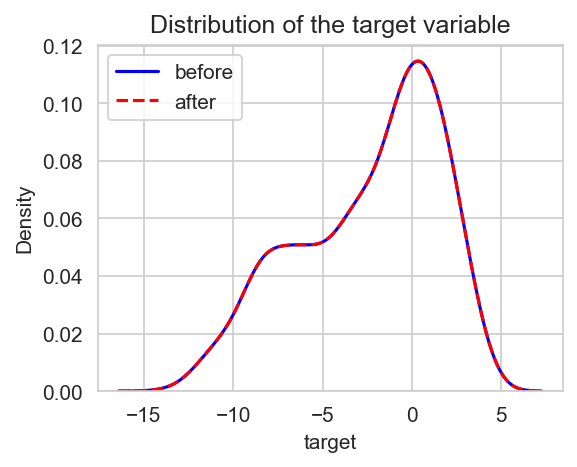

In [19]:
plt.figure(figsize=(4,3), dpi=150)
sns.kdeplot(data=df_copy, x=target, label='before', color='blue')
sns.kdeplot(data=df, x=target, label='after', color='red', linestyle='--')
plt.legend()
plt.title('Distribution of the target variable')
plt.show()

Delete auxiliary variable to clear memory

In [20]:
del df_copy

## EDA

### Single variable analysis

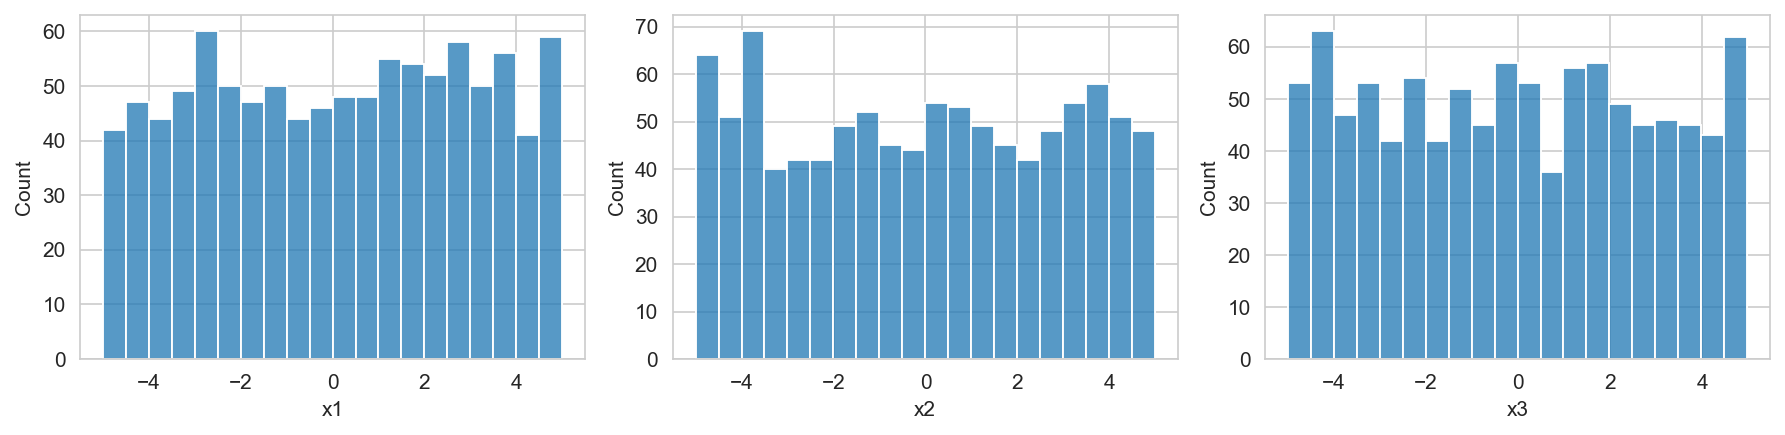

In [21]:
plt.figure(figsize=(12,3), dpi=150)

for i,f in enumerate(num_features):
    plt.subplot(1,3,i+1)
    sns.histplot(data=df, x=f, bins=20)

plt.tight_layout()
plt.show()

**Observations**: features are distributed almost uniformly

Now, let's plot the distribution of the target

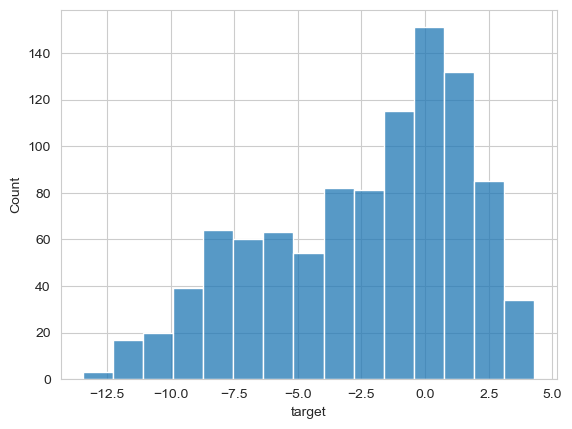

In [22]:
sns.histplot(data=df, x=target)
plt.show()

Target is skewed to the left

### Multivariable analysis

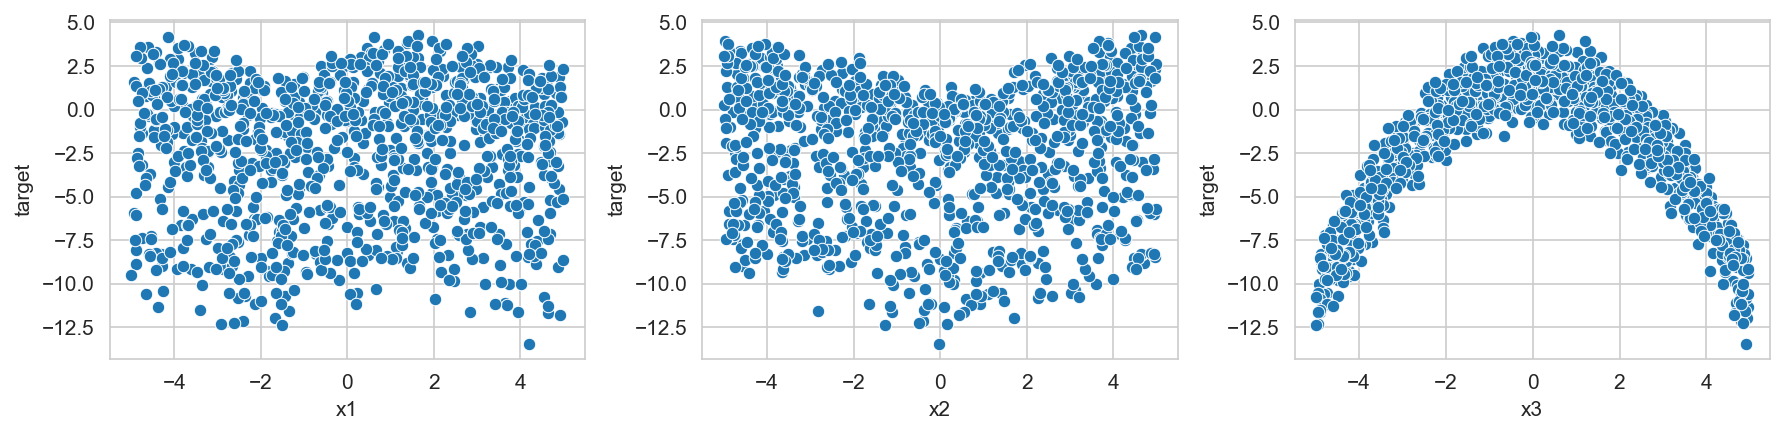

In [23]:
plt.figure(figsize=(12,3), dpi=150)

for i,f in enumerate(num_features):
    plt.subplot(1,3,i+1)
    sns.scatterplot(data=df, x=f, y=target)

plt.tight_layout()
plt.show()

**Observations:**
1. X1 tends to have higher values. We can see slight sinusoidal trend with period=6.
2. X2 seems to have parabolic trend. It tends to have higher values as well. 
3. X3 has strong parabolic trend.

### Correlation matrix

In [24]:
def correlation_heatmap(df:pd.DataFrame) -> None:
    sns.heatmap(
        data=df.corr().abs(),
        cmap='magma',
        annot=True,
        fmt='.1f',
        annot_kws={'size': 8},
        vmax=1,
        vmin=0,
    )
    plt.title('Correlation matrix')

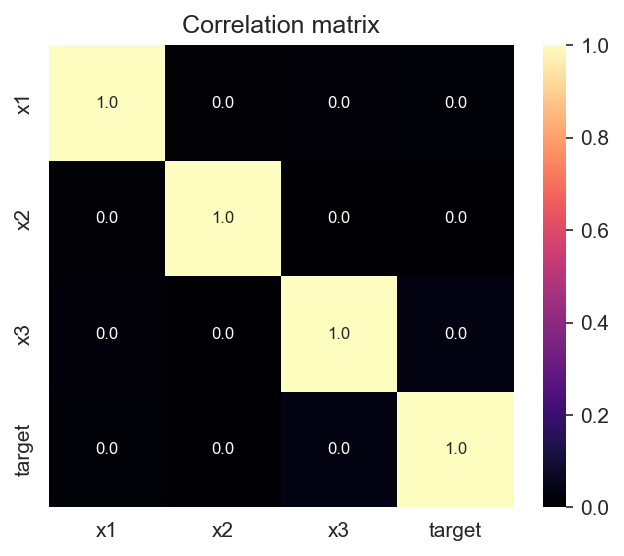

In [25]:
plt.figure(figsize=(5,4), dpi=150)
correlation_heatmap(df.copy())
plt.show()

**Observation:** features do not have linear correlation with the target.

### Mutual information

In [ ]:
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression

def mutual_info_target(df:pd.DataFrame, target:str) -> None:

    X = df.loc[:, df.columns != target]
    y = df[target]

    if y.dtype == int:
        mi_scores = pd.Series(mutual_info_classif(X, y), index=X.columns)
    else:
        mi_scores = pd.Series(mutual_info_regression(X, y), index=X.columns)

    sns.barplot(mi_scores.sort_values(ascending=False), palette='deep')
    plt.title(f'Mutual information for {target}')
    # plt.xticks(rotation=45)


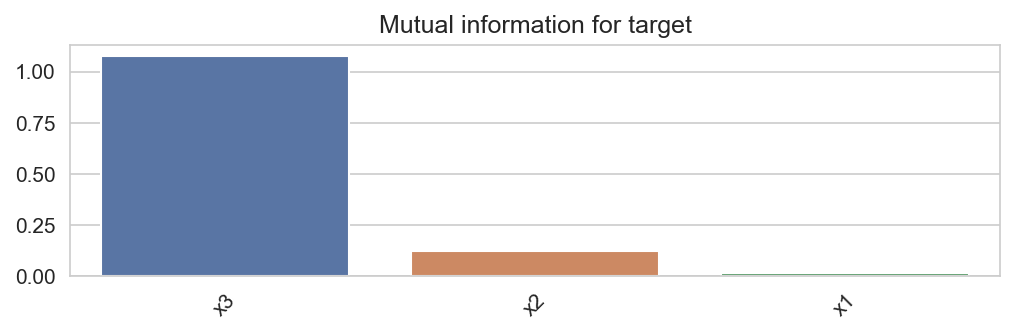

In [27]:
plt.figure(figsize=(8,2), dpi=150)
mutual_info_target(df.copy(), target)
plt.show()

**Observation:** X3 has the strongest correlation with the target, while X1 has very very weak correlation with thr target (X2 correlation is also relatively small).

# Feature engineering

Split the data into X and y

In [28]:
X = df.drop(columns=target)
y = df[target].copy()

Split the data into train and test datasets

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

y_train = pd.Series(y_train)
y_test = pd.Series(y_test)

Plot the data

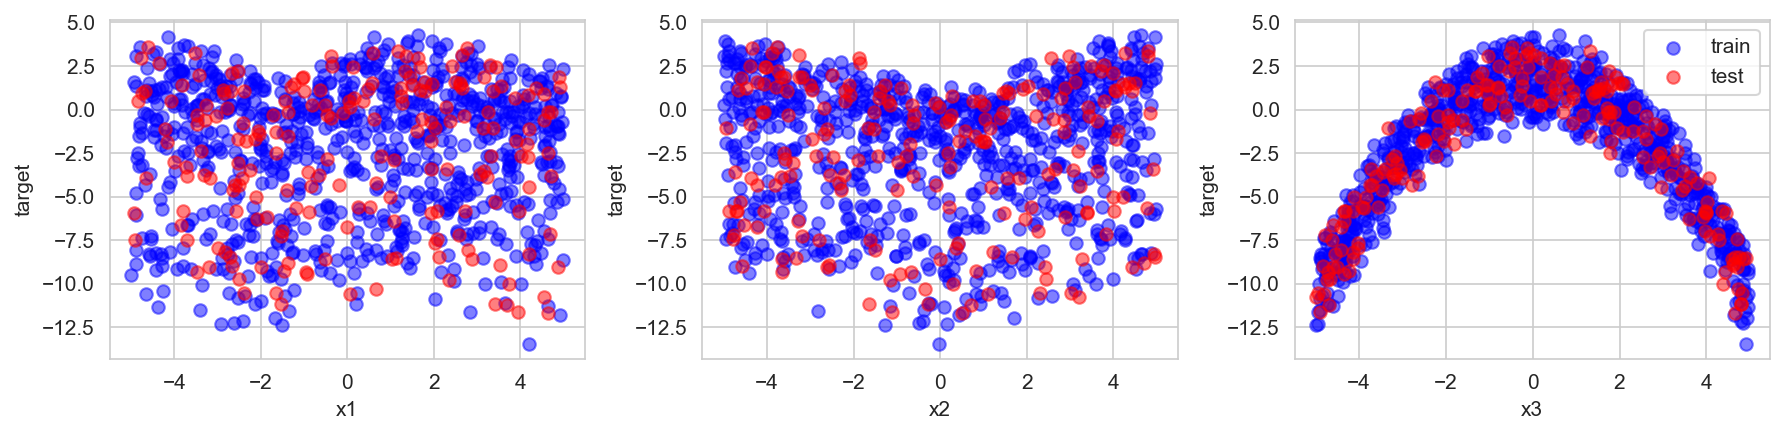

In [30]:
plt.figure(figsize=(12,3), dpi=150)

for i,f in enumerate(num_features):
    plt.subplot(1,3,i+1)
    plt.scatter(X_train[f], y_train, label='train', c='blue', alpha=0.5)
    plt.scatter(X_test[f], y_test, label='test', c='red', alpha=0.5)
    plt.xlabel(f)
    plt.ylabel(target)

plt.legend()
plt.tight_layout()
plt.show()

### Add some new features

In [31]:
X_train['x1_sin'] = np.sin(2 * np.pi * X_train['x1'] / 6)
X_test['x1_sin'] = np.sin(2 * np.pi * X_test['x1'] / 6)

X_train['x1_cos'] = np.cos(2 * np.pi * X_train['x1'] / 6)
X_test['x1_cos'] = np.cos(2 * np.pi * X_test['x1'] / 6)

X_train['x2_log1p'] = np.log1p(X_train['x2']**2)
X_test['x2_log1p'] = np.log1p(X_test['x2']**2)

X_train['x3_squared'] = X_train['x3'] ** 2
X_test['x3_squared'] = X_test['x3'] ** 2

Update the numerical feature list

In [32]:
num_features = ['x1', 'x2', 'x3', 'x1_sin', 'x1_cos', 'x2_log1p', 'x3_squared']

### Feature scaling

In [33]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(X_train[num_features])

X_train[num_features] = scaler.transform(X_train[num_features])
X_test[num_features] = scaler.transform(X_test[num_features])

Convert the data

In [34]:
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

# Modeling

## Linear regression using normal equation

Compute the weights using the solution of the normal equation

In [35]:
def normal_eq(X:np.ndarray, y:np.ndarray, fit_intercept:bool=True):
    if fit_intercept:
        intercept = np.ones((X.shape[0], 1))
        X = np.hstack([X, intercept])
        Wb = np.linalg.pinv(X.T @ X) @ X.T @ y.reshape((len(y), 1))
        Wb = Wb.reshape(X.shape[1], 1)
        return Wb[:-1, :], Wb[-1, 0]
    else:
        W = ((np.linalg.pinv(X.T@X))@X.T)@y
        return W

In [36]:
W_n, b_n = normal_eq(X_train, y_train)

Predict the target (forward pass)

In [37]:
def forward_pass(X:np.ndarray, W:np.ndarray, b:np.ndarray=None) -> np.ndarray:
    if b is None:
        y = X@W
    else:
        y = X@W + b
    return y.squeeze()

In [38]:
y_pred_n = forward_pass(X_test, W_n, b_n)

## Linear regression using gradient descend

Initialize weights and a bias

In [39]:
W_g = np.ones((X_train.shape[1], 1))
b_g = -1

Compute Loss function

In [40]:
def loss_function(y_hat:np.ndarray, y_true:np.ndarray, W:np.ndarray=None, r1:float=0, r2:float=0) -> float:
    l = np.sum(np.power(y_hat - y_true, 2))/(len(y_hat)*2)
    if W is not None:
        l += r1 * np.sum(np.power(W,2))/len(W)
        l += r2 * np.sum(np.abs(W))/(len(W)*2)
    return l

Compute gradients

In [41]:
def gradients(X:np.ndarray, y_hat:np.ndarray, y_true:np.ndarray, W:np.ndarray=None, r1:float=0, r2:float=0):
    gW = (X.T @ (y_hat - y_true).reshape((len(y_true), 1)))/X.shape[0]
    gb = np.sum(y_hat - y_true)/X.shape[0]
    if W is not None:
        gW += r1 * np.sum(W/np.abs(W))
        gW += r2 * np.sum(W)
    return gW, gb

Update weights and the bias

In [42]:
def update_weights(W:np.ndarray,  gW:np.ndarray,  b:float, gb:float, lr:float=0.01):
    W -= lr*gW
    b -= lr*gb
    return W, b

Loop

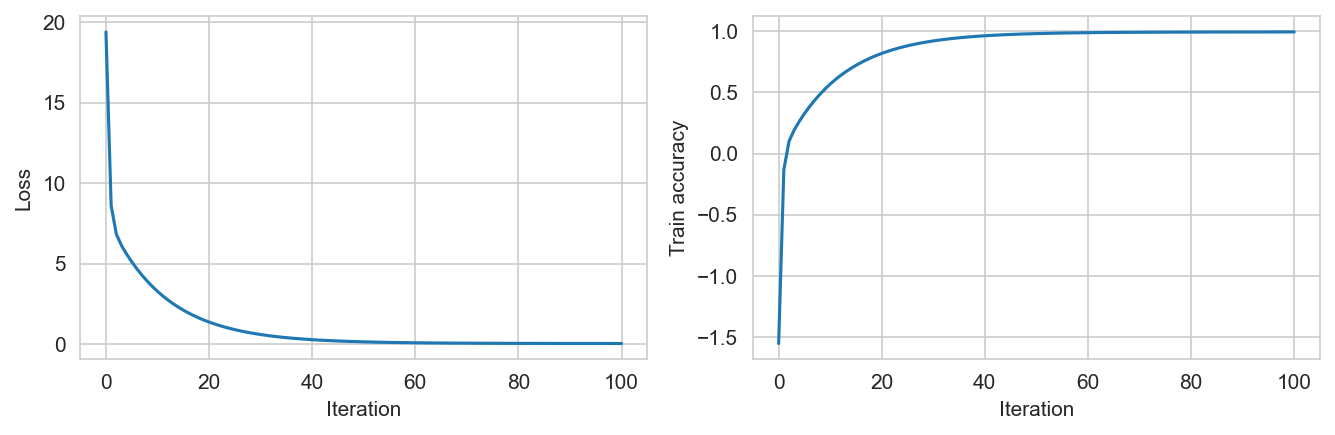

In [43]:
epochs = 100
r1, r2 = 0, 0.001
lr0 = 0.5
decay_rate = 0.001
progress = []
score = []

for epoch in range(epochs):
    y_pred_g = forward_pass(X_train, W_g, b_g)
    gradW, gradb = gradients(X_train, y_pred_g, y_train, W_g, r1, r2)
    lr = lr0 / (1 + decay_rate * epoch)
    W_g, b_g = update_weights(W_g, gradW, b_g, gradb, lr)

    S_res_g = np.sum(np.power(y_pred_g - y_train, 2))
    S_tot_g = np.sum(np.power(y_train.mean() - y_train, 2))
    RR_g = 1 - S_res_g/S_tot_g
    score.append(RR_g)
    progress.append(loss_function(y_pred_g, y_train, W_g, r1, r2))

plt.figure(figsize=(9,3), dpi=150)
plt.subplot(1,2,1)
plt.plot(np.linspace(0, epochs, len(progress)), progress)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.subplot(1,2,2)
plt.plot(np.linspace(0, epochs, len(score)), score)
plt.xlabel('Iteration')
plt.ylabel('Train accuracy')
plt.tight_layout()
plt.show()

Make final prediction

In [44]:
y_pred_g = forward_pass(X_test, W_g, b_g)

## Evaluate results

Evaluate results using $R^2$

In [45]:
S_res_n = np.sum(np.power(y_pred_n - y_test, 2))
S_tot_n = np.sum(np.power(y_test.mean() - y_test, 2))
RR_n = 1 - S_res_n/S_tot_n

S_res_g = np.sum(np.power(y_pred_g - y_test, 2))
S_tot_g = np.sum(np.power(y_test.mean() - y_test, 2))
RR_g = 1 - S_res_g/S_tot_g

print('R^2 using normal equation:', round(RR_n, 4))
print('R^2 using gradient descend:', round(RR_g, 4))

R^2 using normal equation: 0.9945
R^2 using gradient descend: 0.9931
